<a href="https://colab.research.google.com/github/kohi2112002/WineQuality/blob/FINAL/WineQuality_CMForAll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone **DATA**


In [20]:
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, metrics, model_selection, svm

In [21]:
!git clone https://github.com/kohi2112002/WineQuality.git

fatal: destination path 'WineQuality' already exists and is not an empty directory.


In [22]:
# upload file to drive
red_path = '/content/WineQuality/winequality-red.csv'
white_path = '/content/WineQuality/winequality-white.csv'

In [23]:
# read file into dataframe
red_df = pd.read_csv(red_path)
white_df = pd.read_csv(white_path)
full = pd.concat([red_df, white_df])

In [24]:
# check 
print(red_df.shape)
print(white_df.shape)

(1599, 12)
(4898, 12)


# **Check data**

Text(0.5, 1.0, 'Correlation between variables')

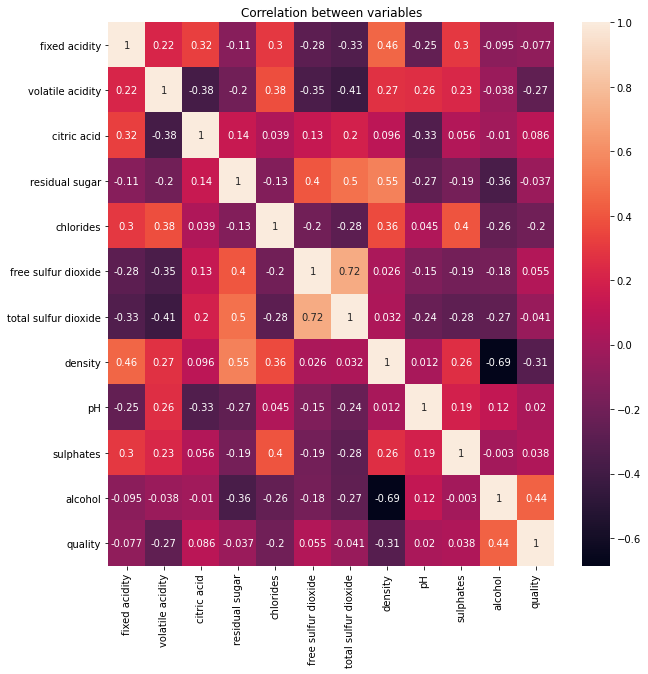

In [25]:
#Check correlation
corr = full.corr()
fig, ax = plt.subplots(figsize = (10,10))
g= sns.heatmap(corr,ax=ax, annot= True)
ax.set_title('Correlation between variables')

In [26]:
corr_vec = full.corr()['quality']
print(abs(corr_vec) > 0.05)
print((abs(corr_vec)).idxmin())

fixed acidity            True
volatile acidity         True
citric acid              True
residual sugar          False
chlorides                True
free sulfur dioxide      True
total sulfur dioxide    False
density                  True
pH                      False
sulphates               False
alcohol                  True
quality                  True
Name: quality, dtype: bool
pH


In [27]:
#Remove not needed data
opt_data = full.drop(['residual sugar','pH','sulphates','total sulfur dioxide'], axis = 1)

In [28]:
#Scale data with MinMax Scaler
scaler = MinMaxScaler()

#this function return scaled data
def Khoi_Scaler(data):
  scaler.fit(data)
  return scaler.transform(data)

In [29]:
#Scale data with Robust Scaler
transform = RobustScaler()

#this funtion return scaled data
def Khoi_Robust(data):
  return transform.fit_transform(data)

In [30]:
#Scale data with Standard Scaler
khoi_scaler = StandardScaler()

#this function return data scaled by Standard Scaler
def Khoi_SD_Scaler(data):
  return khoi_scaler.fit_transform(data)

In [31]:
#Data partition

#This is function return train and target data set
def needed_data(data, target_label, index):
  #Scale data
  data = Khoi_Robust(data)
  # data = Khoi_SD_Scaler(data)
  # data = Khoi_Scaler(data)
  #split data
  X_train_full1, X_test_full1,Y_train_full1,Y_test_full1 = train_test_split(np.delete(data, index, axis = 1),data[:,index], test_size = 0.1, random_state = 100)
  X_train_full2, X_test_full2,Y_train_full2, Y_test_full2 = train_test_split(np.delete(data, index, axis = 1),data[:,index], test_size = 0.1, random_state = 220)
  X_train_full3, X_test_full3,Y_train_full3,Y_test_full3 = train_test_split(np.delete(data, index, axis = 1),data[:,index], test_size = 0.1, random_state = 343)
  #store data
  train_full = [X_train_full1, X_train_full2, X_train_full3]
  test_full = [X_test_full1, X_test_full2, X_test_full3]
  Y_test_full = [Y_test_full1, Y_test_full2, Y_test_full3]  
  #return data
  return [train_full, test_full, Y_test_full]

# **K mean clustering**

## **Preparation**

In [32]:
all_label_target = opt_data.columns

In [40]:
#This function calculate the 
def re_cm(cnf_matrix):
  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)

  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)

  TPR[np.isnan(TPR)] = mean(TPR[np.logical_not(np.isnan(TPR))])
  FNR[np.isnan(FNR)] = mean(FNR[np.logical_not(np.isnan(FNR))])
  PPV[np.isnan(PPV)] = mean(PPV[np.logical_not(np.isnan(PPV))])

  return [ACC, TPR, FPR, FNR, PPV]

In [39]:
#This function plot the train data and centroid
def Khoi_PLOT(train_data, centers, train_labels, figure, _title):
  plt.figure(k)
  plt.title(_title)
  plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=50, cmap='viridis')
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

In [45]:
#This function plot ROC curve
def Khoi_ROC(TP, FP, index, label):
  fig = plt.figure(figsize=(100,50))
  plt.subplot(12,3, index + 1)
  plt.title(label)  
  sns.lineplot(x=FP, y=TP)

## **K mean with 2 cluster**

THE CONFUSION MATRIX OF fixed acidity in 0th test: 
    0    1
0  62  329
1  78  181

The centroids of fixed acidity in 0th test: 
[[ 1.60607309 -0.55095273  1.74325173 -0.44201363  0.36432675 -0.11227108
  -0.63596168]
 [-0.09783178  0.25257716 -0.08423658  0.21330271 -0.16199943  0.17260208
  -0.04365256]]

The Accuracy is: 0.37384615384615383 
The True positive rate is: 0.4287047368888801 
The False Positive Rate is: 0.5712952631111199 
The False Negative Rate is:0.5712952631111199 
The Precision is 0.3988795518207283

The Mean Performance of fixed acidity in 0th test is: 0.4925437037329621
THE CONFUSION MATRIX OF fixed acidity in 1th test: 
    0    1
0  61  322
1  90  177

The centroids of fixed acidity in 1th test: 
[[ 1.59537197 -0.60021008  1.6837146  -0.44329044  0.35484345 -0.11279956
  -0.63529412]
 [-0.09985055  0.25290522 -0.08529167  0.21775407 -0.16217699  0.17131549
  -0.04279028]]

The Accuracy is: 0.36615384615384616 
The True positive rate is: 0.4110951389092616 
The

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 1th test: 
     0   1
0  152  81
1  337  80

The centroids of quality in 1th test: 
[[-0.11401809 -0.07681319  0.15612451 -0.12043908  0.24003073 -0.19004379
   0.15404018]
 [ 1.04645604  1.4737605  -0.26841837  1.74481481 -0.49516369  0.42858833
  -0.0498082 ]]

The Accuracy is: 0.3569230769230769 
The True positive rate is: 0.4221035189016169 
The False Positive Rate is: 0.5778964810983831 
The False Negative Rate is:0.5778964810983831 
The Precision is 0.40386642787282956

The Mean Performance of quality in 1th test is: 0.4954407272428032
THE CONFUSION MATRIX OF quality in 2th test: 
    0    1
0  76  151
1  77  346

The centroids of quality in 2th test: 
[[ 1.02897674  1.47893453 -0.26432145  1.7982686  -0.48342566  0.43019054
  -0.0523853 ]
 [-0.10621022 -0.07585035  0.16553186 -0.11427525  0.24254815 -0.18506469
   0.15574166]]

The Accuracy is: 0.6492307692307693 
The True positive rate is: 0.5763843325939118 
The False Positive Rate is: 0.4236

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


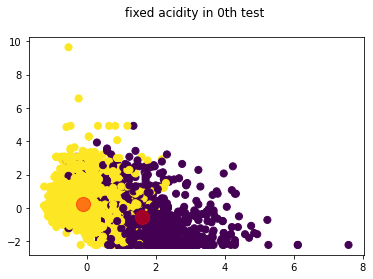

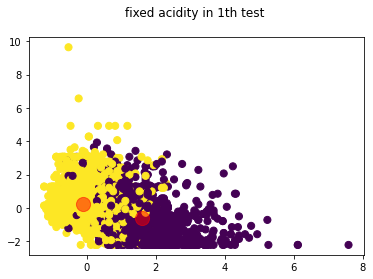

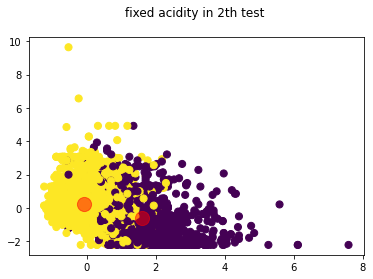

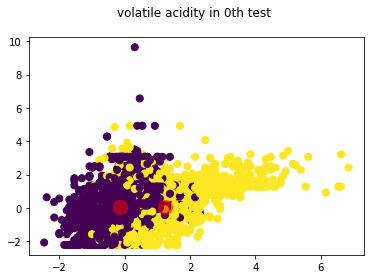

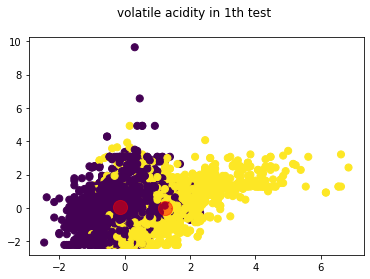

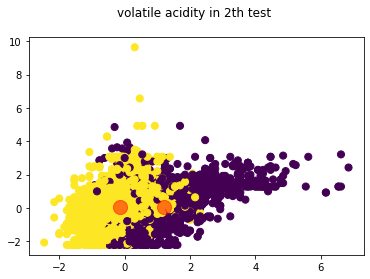

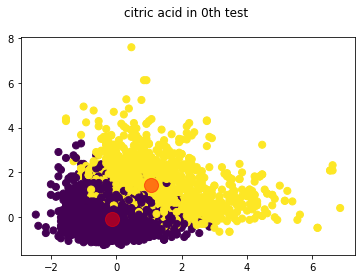

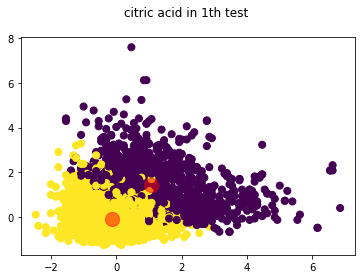

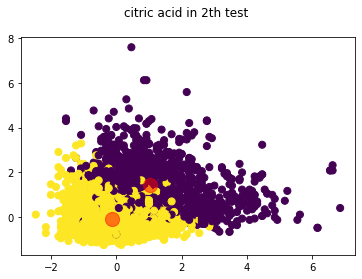

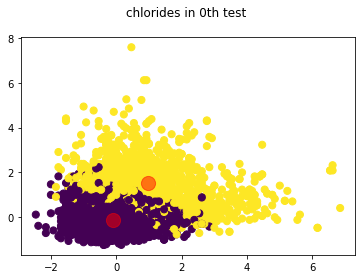

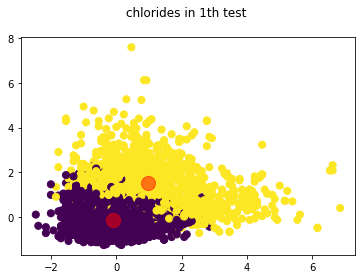

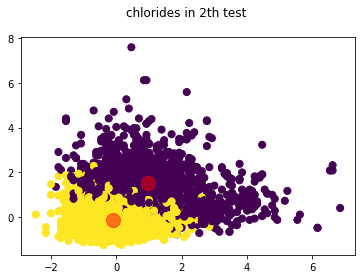

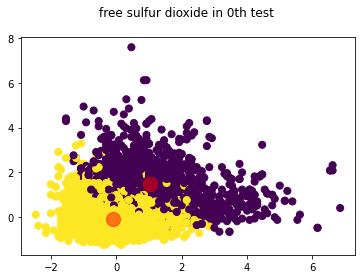

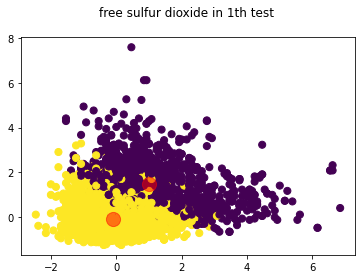

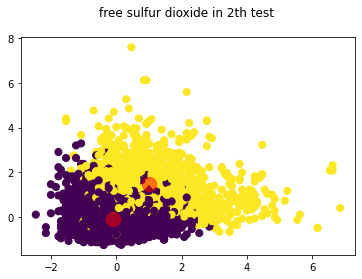

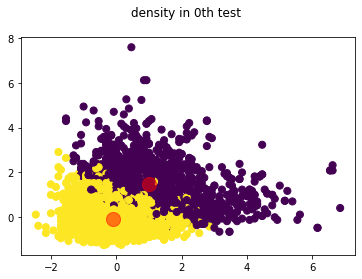

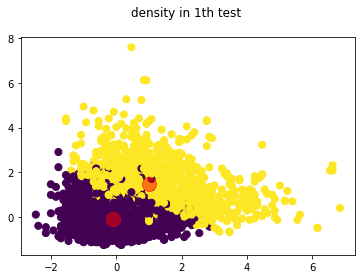

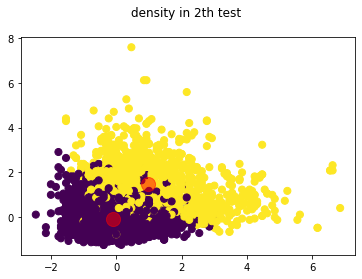

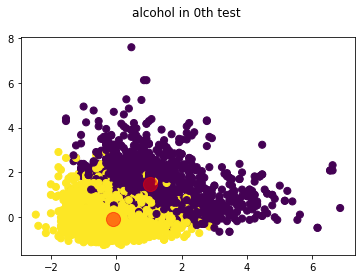

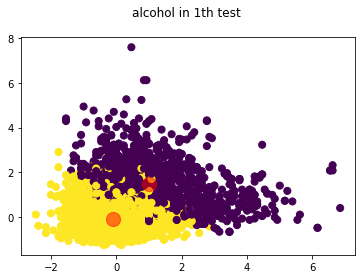

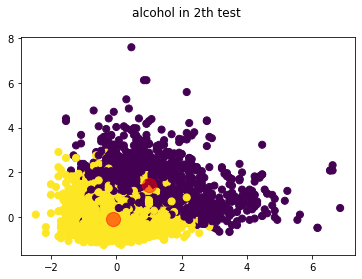

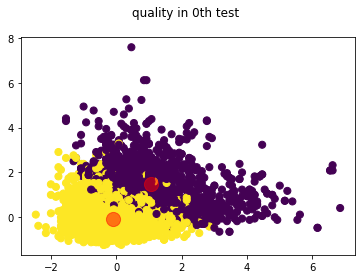

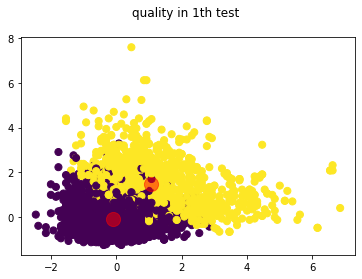

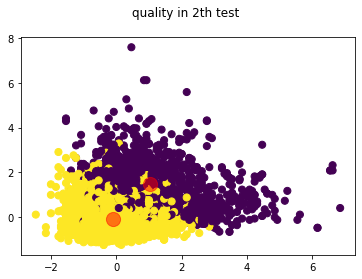

In [48]:
len_target = len(all_label_target)
k = 0
index = 0
lb_2_lst = []
TP_lst = []
FP_lst = []
while index < len_target:
  # Get needed data
  [train, test, y_actual] = needed_data(opt_data, all_label_target[index], index)
  #Train
  pred = []
  centroids = []
  j = 0
  while j < len(train):
    #Train
    model_kmeans = KMeans(n_clusters=2, random_state=0).fit(train[j])
    centroids.append(model_kmeans.cluster_centers_)
    #Test
    pred.append(model_kmeans.predict(test[j]))
    #Confusion Matrix
    y_actual[j][y_actual[j] > np.mean(y_actual[j])] = 1
    y_actual[j][y_actual[j] <= np.mean(y_actual[j])] = 0
    cmatrix = confusion_matrix(y_actual[j].astype(np.int16), pred[j])
    cm_table = pd.DataFrame(cmatrix)
    cal = re_cm(cmatrix)
    print("THE CONFUSION MATRIX OF {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, cm_table))
    print("The centroids of {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, centroids[j]))
    print("The Accuracy is: {0} \nThe True positive rate is: {1} \nThe False Positive Rate is: {2} \nThe False Negative Rate is:{3} \nThe Precision is {4}\n".format(np.mean(cal[0]), np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])))
    print("The Mean Performance of {0} in {1}th test is: {2}".format(all_label_target[index], j, mean([np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])])))    
    Khoi_PLOT(train[j], centroids[j], model_kmeans.labels_, k, "{0} in {1}th test \n".format(all_label_target[index], j))
    #Store
    lb_2_lst.append("{0} in {1}th test \n".format(all_label_target[index], j))
    TP_lst.append(cal[1])
    FP_lst.append(cal[2])
    k += 1
    j += 1
  index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

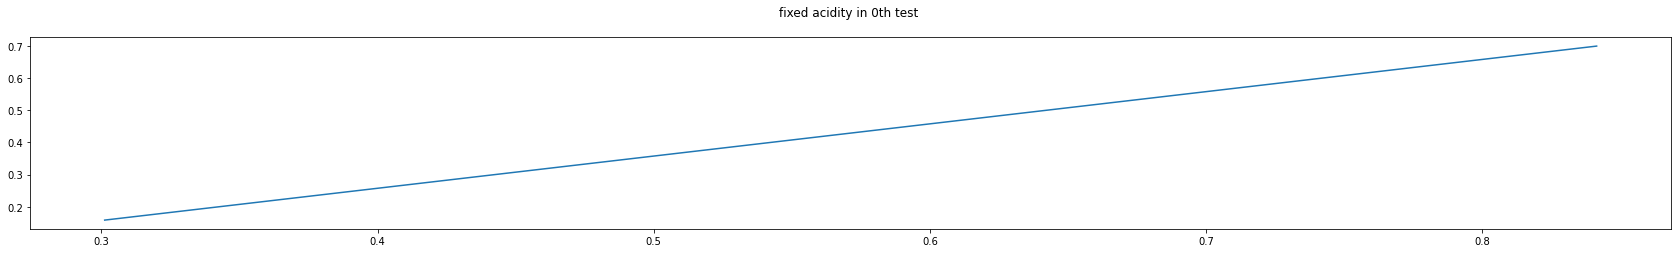

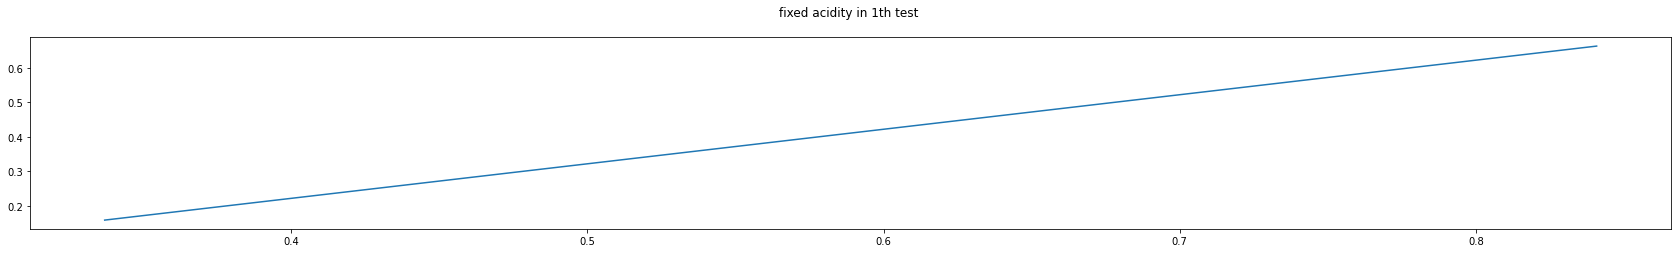

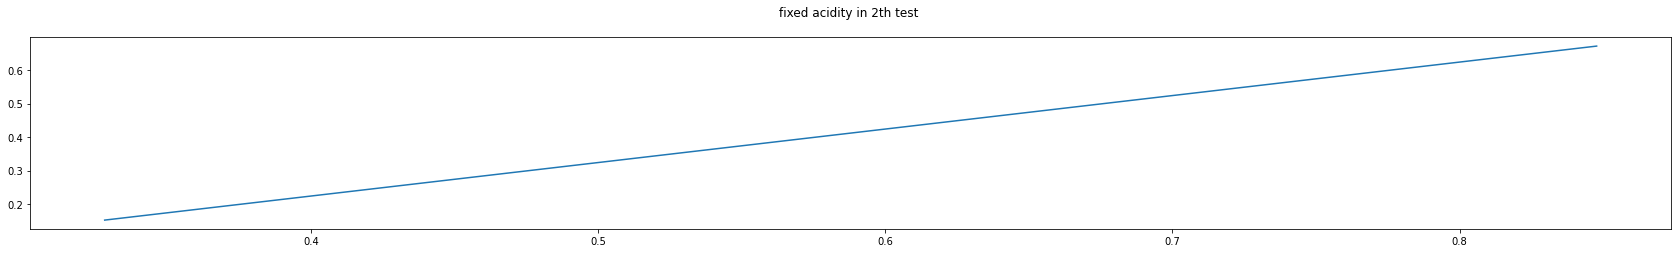

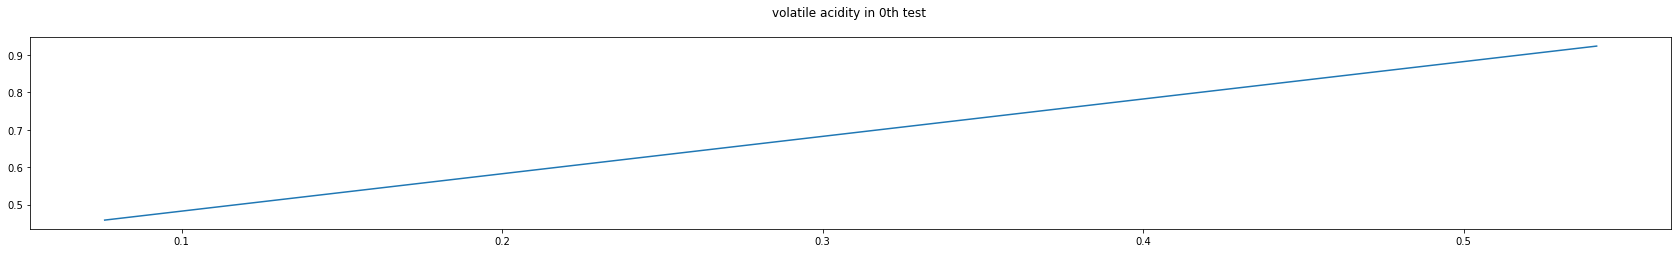

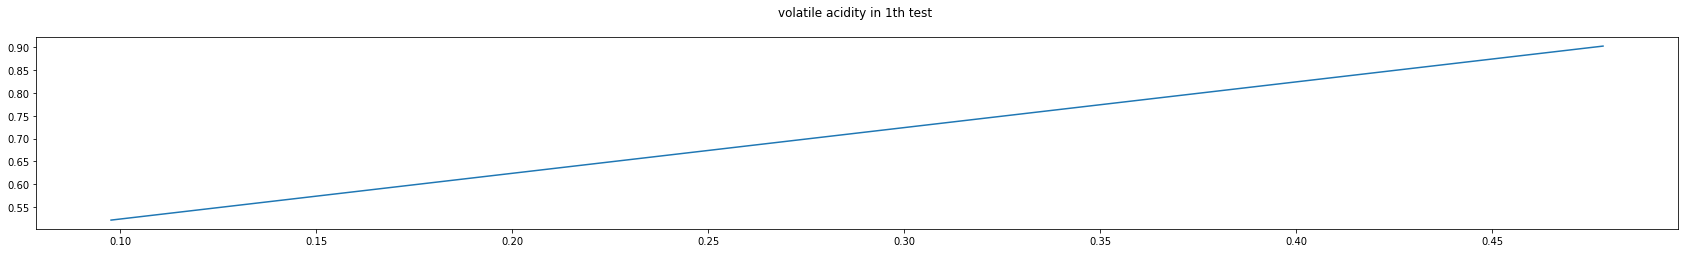

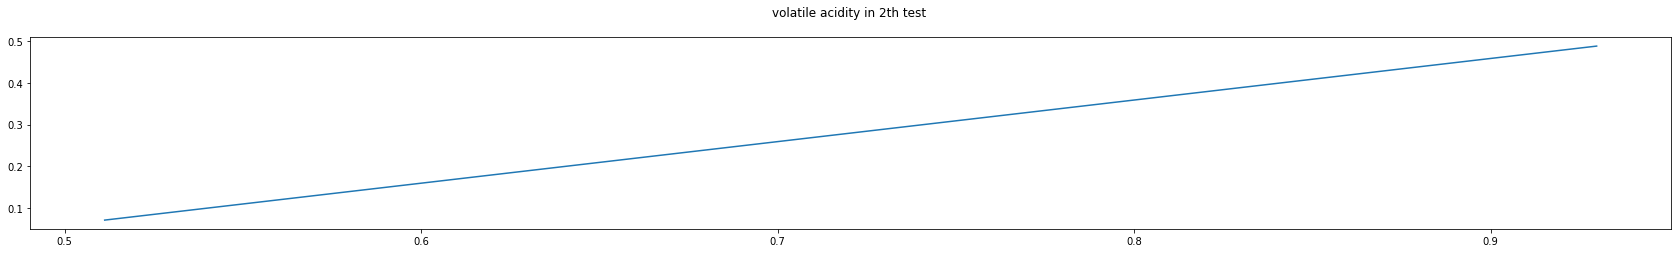

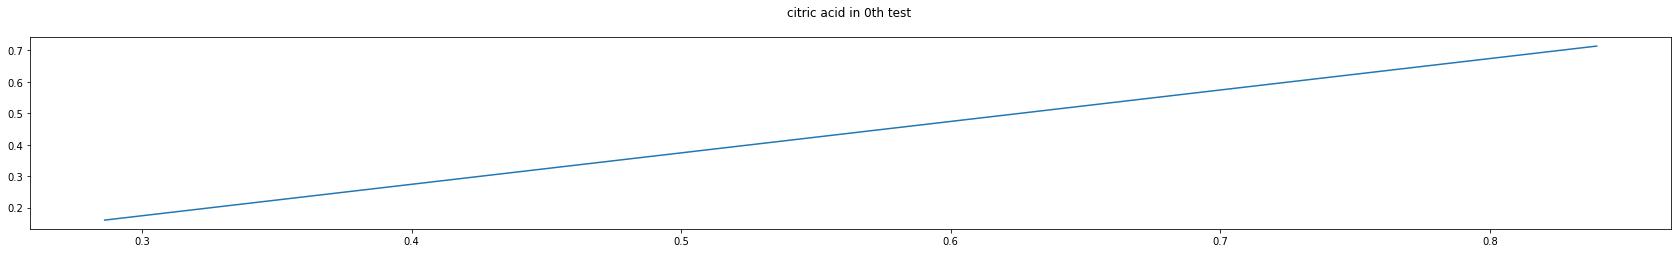

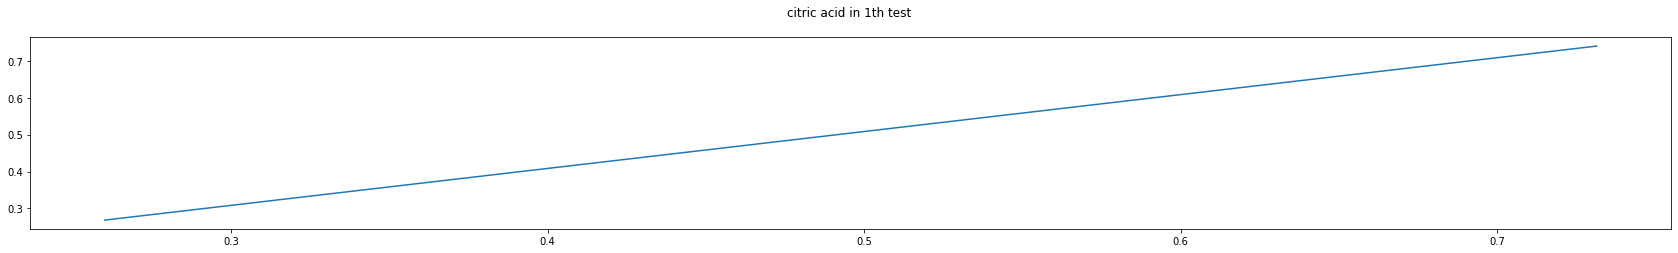

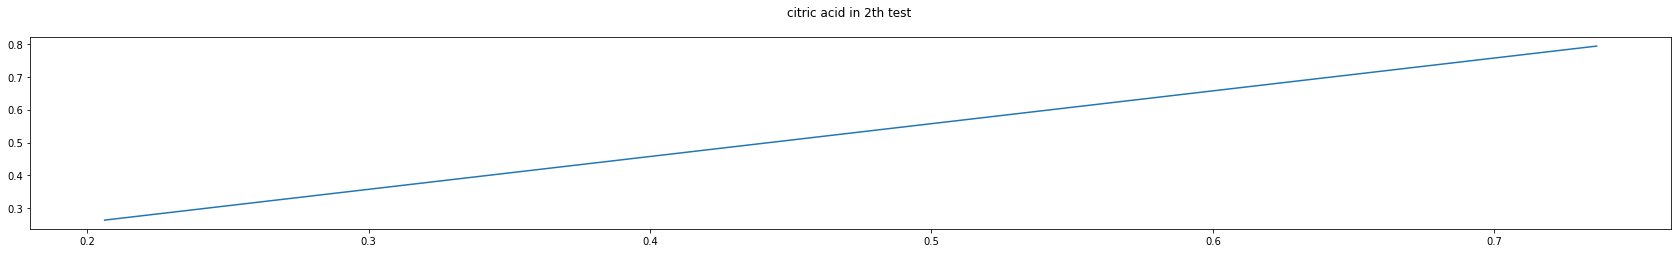

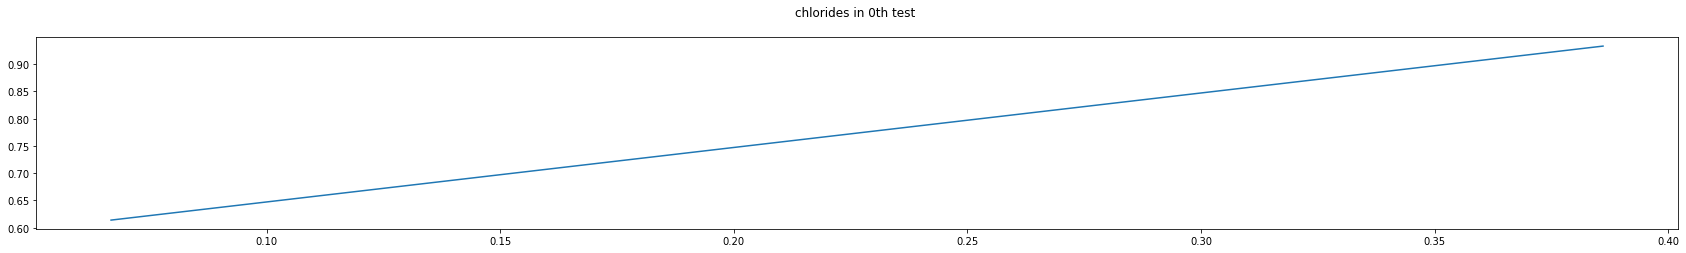

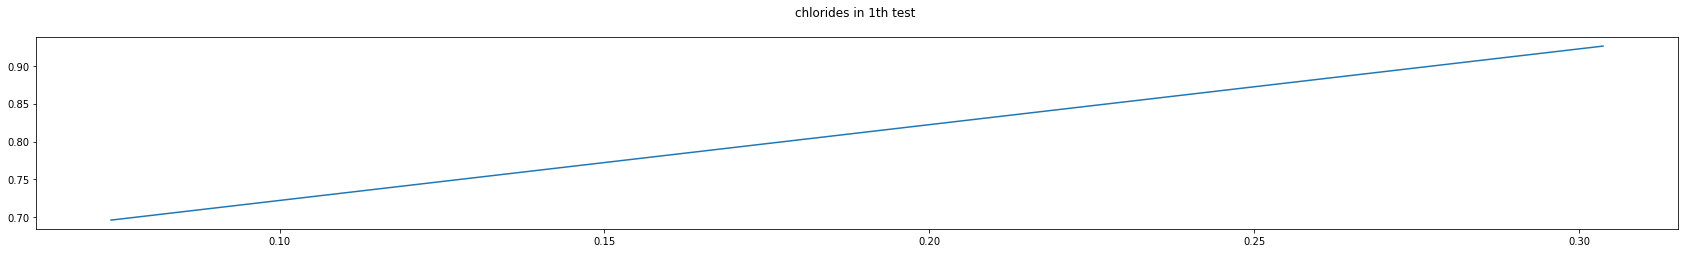

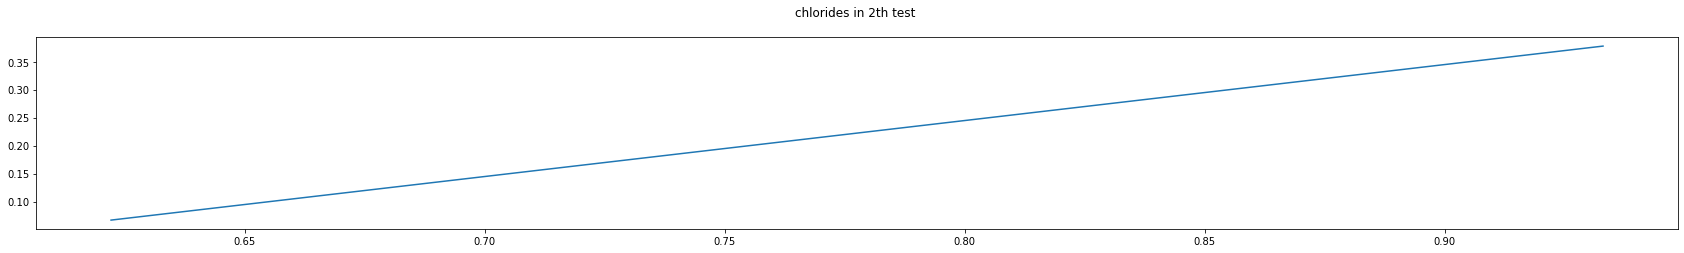

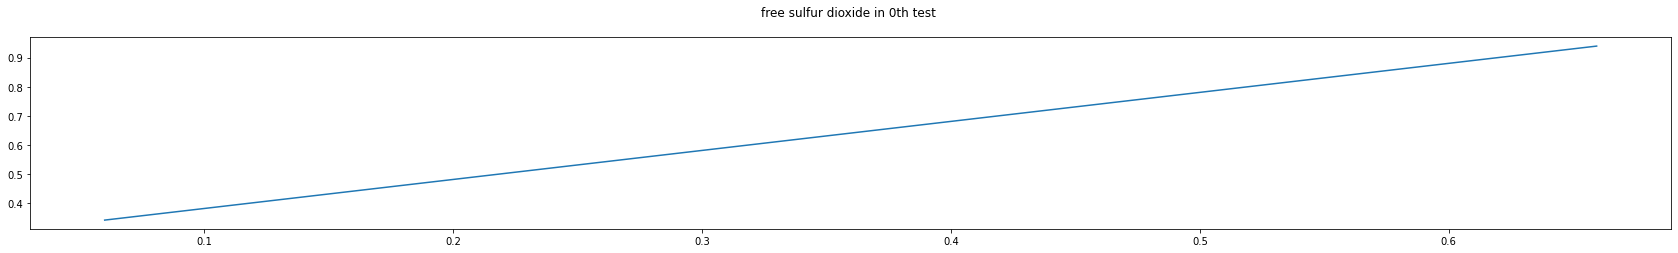

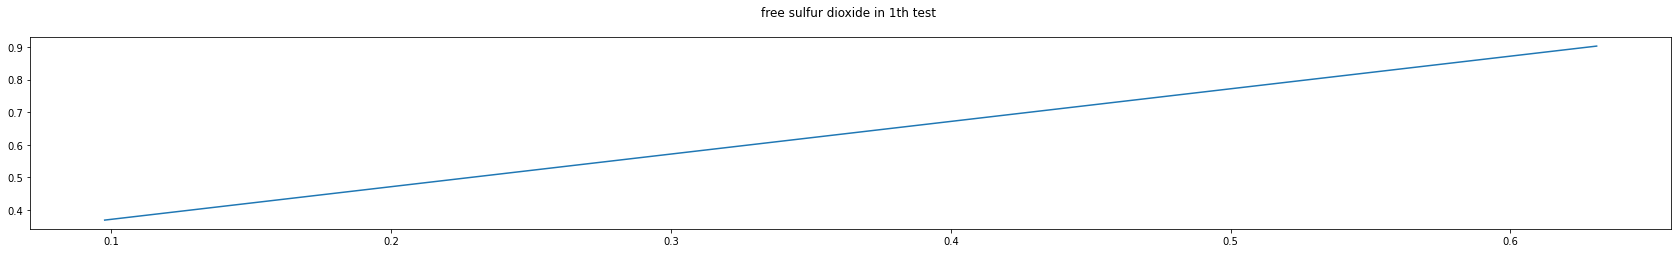

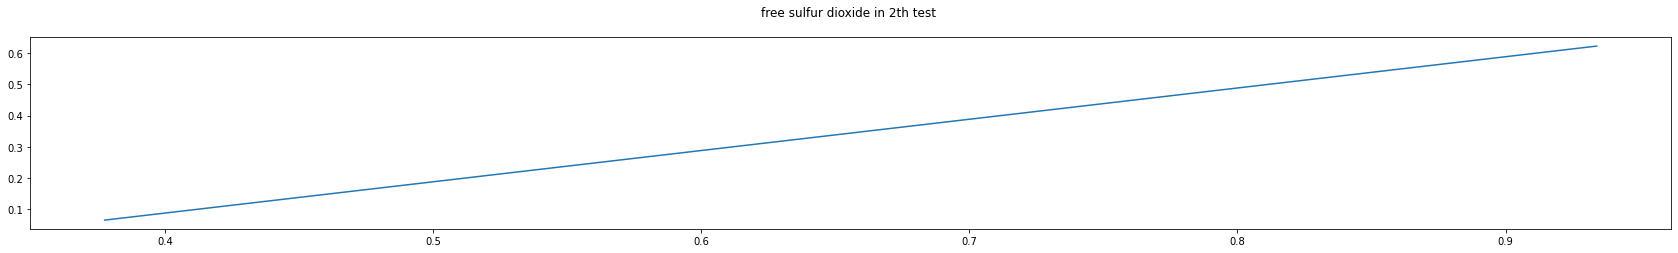

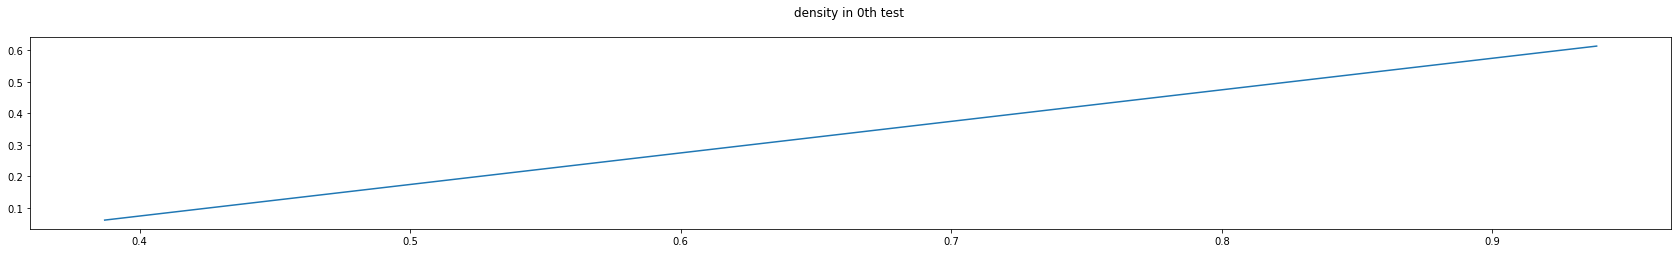

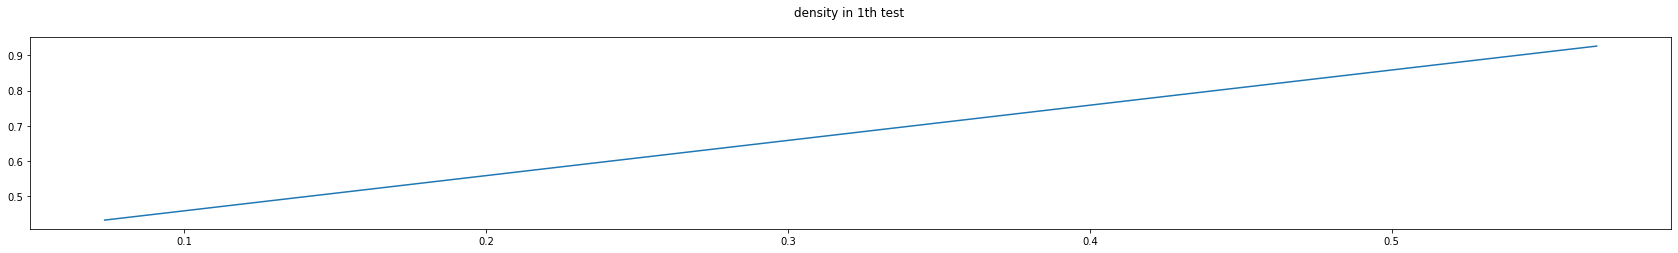

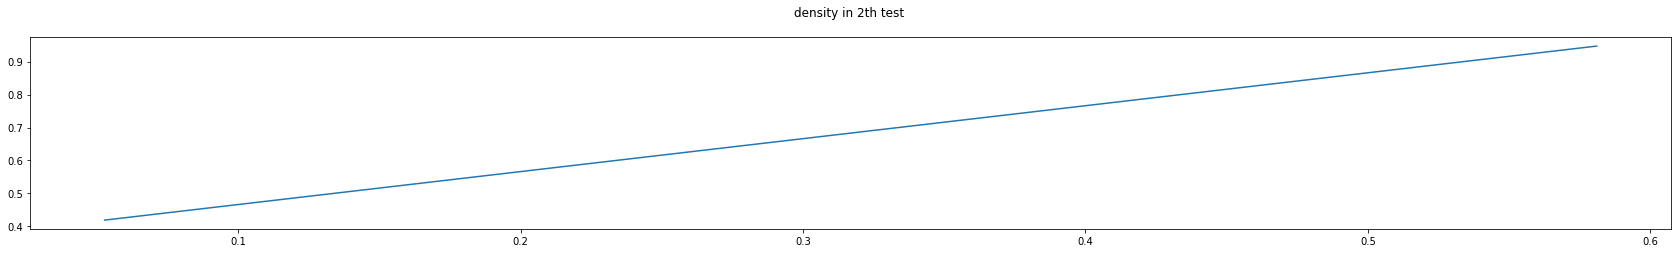

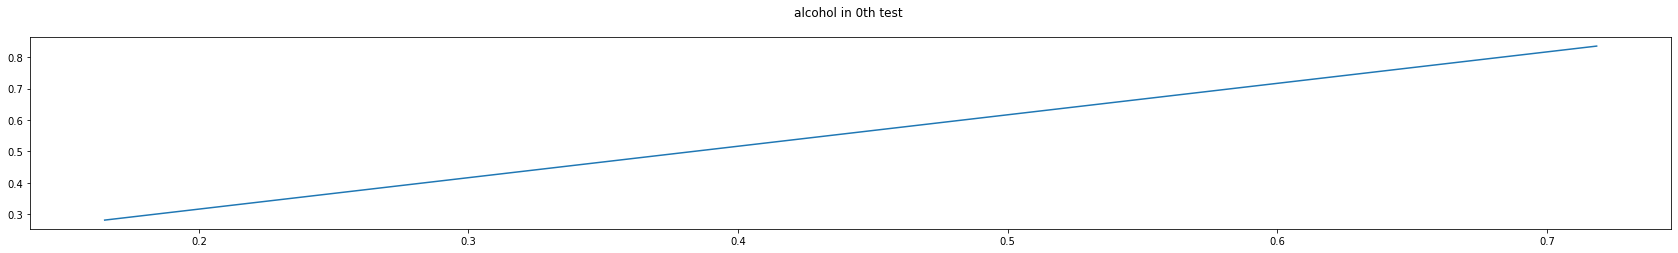

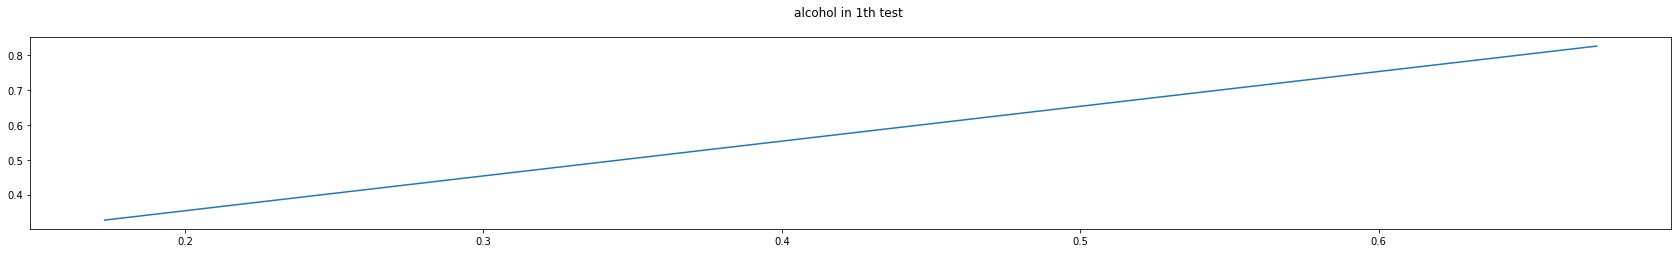

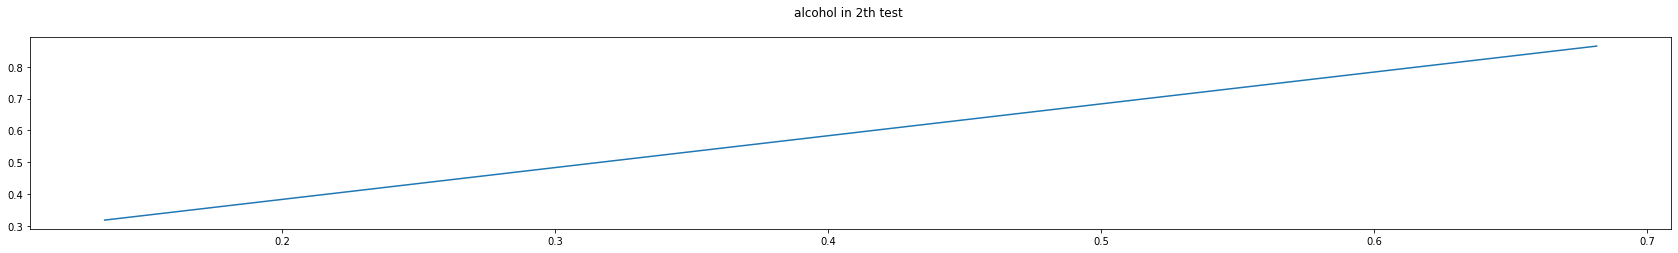

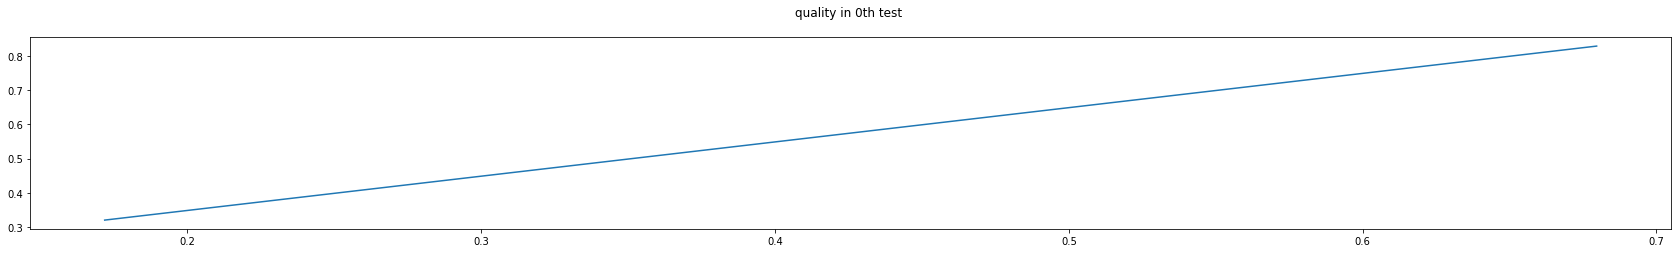

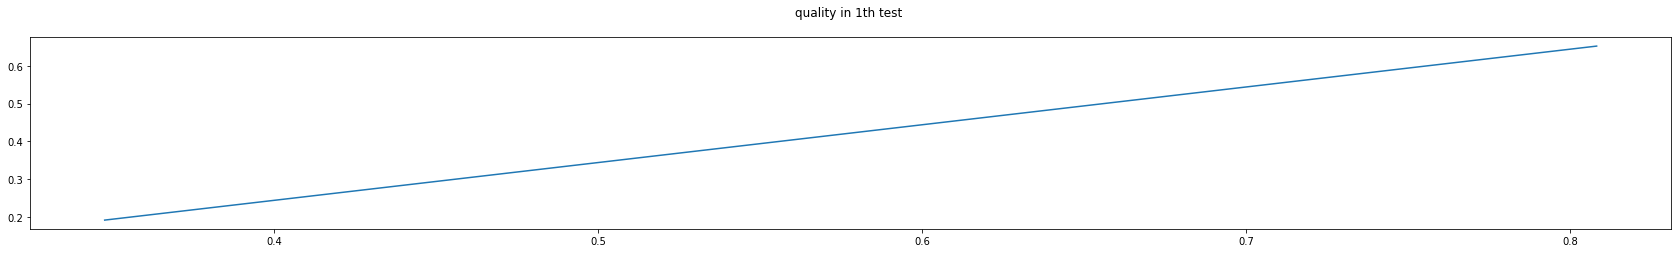

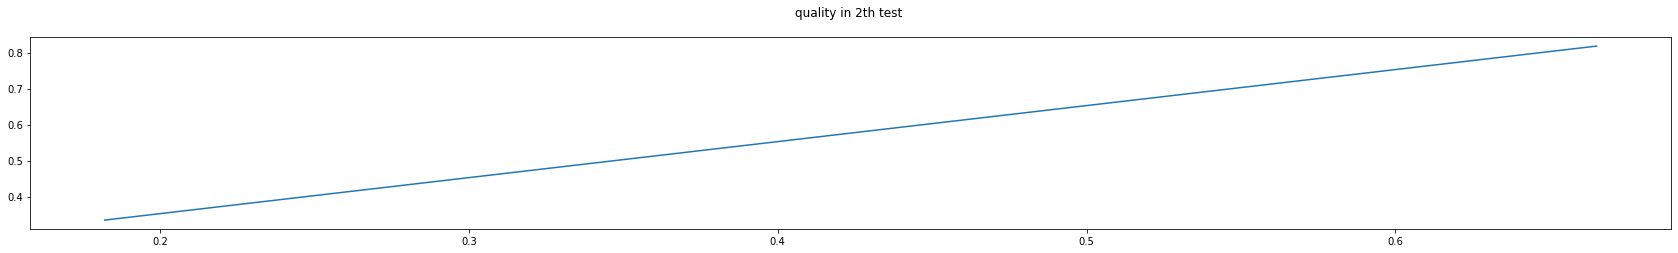

In [50]:
#ROC Curve for 2 cluster
for n in range(len(lb_2_lst)):
  Khoi_ROC(TP_lst[n], FP_lst[n], n, lb_2_lst[n])

## **K mean with 3 cluster**

THE CONFUSION MATRIX OF fixed acidity in 0th test: 
     0    1   2
0  117  495  10
1   13   10   3
2    1    1   0

The centroids of fixed acidity in 0th test: 
[[ 1.71858015 -0.89446326  1.1342479  -0.46657809  0.3185829  -0.10241967
  -0.7007359 ]
 [-0.09957965  0.30118572 -0.04248656  0.20567022 -0.14336631  0.17613593
  -0.02996005]
 [ 0.73778664  1.04418886  6.70872567  0.01518362  0.19826863 -0.38794727
  -0.56779661]]

The Accuracy is: 0.4635897435897436 
The True positive rate is: 0.19090609283535329 
The False Positive Rate is: 0.43831117442228545 
The False Negative Rate is:0.8090939071646467 
The Precision is 0.3042975389473896

The Mean Performance of fixed acidity in 0th test is: 0.43565217834241876
THE CONFUSION MATRIX OF fixed acidity in 1th test: 
     0    1    2
0  119  228  278
1    8    2   13
2    0    0    2

The centroids of fixed acidity in 1th test: 
[[ 1.77741114 -0.85499748  1.7525193  -0.4687684   0.33614879 -0.10029774
  -0.6245583 ]
 [-0.08493757  0.06454

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF citric acid in 1th test: 
     0    1    2
0  273  214  144
1    7    1    9
2    1    0    1

The centroids of citric acid in 1th test: 
[[-0.00838702 -0.05779054  0.05767829  0.37610961  0.18541851 -0.30524179
  -0.54882285]
 [-0.24601435 -0.06478208 -0.31947803  0.04095423 -0.68138281  0.76871522
   0.52953368]
 [ 1.096937    1.50561175  1.79057036 -0.51233346  0.44460663 -0.05841154
  -0.49472097]]

The Accuracy is: 0.6153846153846154 
The True positive rate is: 0.33049004070724963 
The False Positive Rate is: 0.3317454708387609 
The False Negative Rate is:0.6695099592927504 
The Precision is 0.3275583061315081

The Mean Performance of citric acid in 1th test is: 0.41482594424256725
THE CONFUSION MATRIX OF citric acid in 2th test: 
     0    1    2
0  267  133  230
1    7   11    1
2    0    1    0

The centroids of citric acid in 2th test: 
[[-6.54917838e-04 -6.67455837e-02  6.39118220e-02  3.80611455e-01
   1.92569659e-01 -3.05531189e-01 -5.47213622e-01]
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF density in 0th test: 
    0    1    2
0  53  486  110
1   0    0    0
2   0    1    0

The centroids of density in 0th test: 
[[ 2.02631226  0.7026486   1.28658689  2.48232176 -0.45866056  0.04107685
  -0.23211169]
 [-0.0959867  -0.12466664  0.20383234 -0.12466613  0.25918585  0.16091187
  -0.04674654]
 [ 0.23893805  1.83703511 -1.19813176  1.07738811 -0.47455752 -0.08447139
  -0.71484759]]

The Accuracy is: 0.3876923076923077 
The True positive rate is: 0.040832049306625574 
The False Positive Rate is: 0.3062407648848327 
The False Negative Rate is:0.9591679506933745 
The Precision is 0.3333333333333333

The Mean Performance of density in 0th test is: 0.40989352455454153
THE CONFUSION MATRIX OF density in 1th test: 
     0   1    2
0  472  70  106
1    1   0    0
2    1   0    0

The centroids of density in 1th test: 
[[-0.10640334 -0.12491544  0.19730446 -0.12702635  0.26191035  0.15927143
  -0.04811077]
 [ 2.07339574  0.69239548  1.25610985  2.36599386 -0.456

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


THE CONFUSION MATRIX OF density in 2th test: 
    0    1    2
0  46  460  112
1  12   18    2
2   0    0    0

The centroids of density in 2th test: 
[[ 2.03246934  0.75634058  1.25245859  2.58937198 -0.44146286  0.01043344
  -0.25543478]
 [-0.08782606 -0.12335895  0.21203218 -0.11818268  0.26110559  0.15892602
  -0.05211498]
 [ 0.21751969  1.81299213 -1.21273903  1.06678332 -0.46362369 -0.06530694
  -0.70472441]]

The Accuracy is: 0.398974358974359 
The True positive rate is: 0.3184668284789644 
The False Positive Rate is: 0.4315737283213012 
The False Negative Rate is:0.6815331715210355 
The Precision is 0.2769201173471842

The Mean Performance of density in 2th test is: 0.4271234614171213
THE CONFUSION MATRIX OF alcohol in 0th test: 
    0    1    2
0  54  420  105
1   1   63    6
2   0    1    0

The centroids of alcohol in 0th test: 
[[ 2.04604645  0.72179448  1.31313887  2.44812876 -0.45706079  0.56851133
  -0.2390925 ]
 [-0.09900954 -0.12709393  0.19951665 -0.12132762  0.2589432

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 2

THE CONFUSION MATRIX OF alcohol in 2th test: 
    0    1    2
0  58  113  413
1   2    1   63
2   0    0    0

The centroids of alcohol in 2th test: 
[[ 2.05325444  0.76154898  1.24533606  2.54455708 -0.44935152  0.57890242
  -0.25402504]
 [ 0.2157026   1.81377374 -1.20746625  1.06485127 -0.46062992  0.22519897
  -0.70177165]
 [-0.09358794 -0.12566782  0.21000535 -0.1162956   0.26257705 -0.18111886
  -0.05266854]]

The Accuracy is: 0.3938461538461538 
The True positive rate is: 0.057233291822332916 
The False Positive Rate is: 0.3187012910985514 
The False Negative Rate is:0.9427667081776671 
The Precision is 0.32514619883040935

The Mean Performance of alcohol in 2th test is: 0.4109618724822402
THE CONFUSION MATRIX OF quality in 0th test: 
     0   1    2
0  468  55  106
1   21   0    0
2    0   0    0

The centroids of quality in 0th test: 
[[-0.0969417  -0.11739375  0.19498204 -0.12229292  0.2536565  -0.18583303
   0.15589265]
 [ 2.04376426  0.71676419  1.30142109  2.45840605 -0.460

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 1th test: 
     0    1   2
0  459  100  69
1   21    0   1
2    0    0   0

The centroids of quality in 1th test: 
[[-0.10546021 -0.11848955  0.19013241 -0.12422157  0.25824309 -0.18869641
   0.15373691]
 [ 0.22990932  1.86038379 -1.24027294  1.1258657  -0.47980183  0.23821575
  -0.06979261]
 [ 2.0819251   0.70272925  1.26977153  2.34218577 -0.46148213  0.58129524
   0.0418538 ]]

The Accuracy is: 0.8041025641025641 
The True positive rate is: 0.3654458598726114 
The False Positive Rate is: 0.40715781034252374 
The False Negative Rate is:0.6345541401273885 
The Precision is 0.31875000000000003

The Mean Performance of quality in 1th test is: 0.4314769525856309


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


THE CONFUSION MATRIX OF quality in 2th test: 
    0    1    2
0  59  107  466
1   1    1   16
2   0    0    0

The centroids of quality in 2th test: 
[[ 2.04202026  0.73890517  1.25101678  2.53018321 -0.44888049  0.57329048
   0.02131936]
 [ 0.22512925  1.85410926 -1.2317428   1.11465641 -0.47053208  0.23489696
  -0.05601758]
 [-0.09332487 -0.11720961  0.20288171 -0.11830678  0.25955729 -0.17991849
   0.15395762]]

The Accuracy is: 0.39487179487179486 
The True positive rate is: 0.07445499296765119 
The False Positive Rate is: 0.3221326048541238 
The False Negative Rate is:0.9255450070323489 
The Precision is 0.3308641975308642

The Mean Performance of quality in 2th test is: 0.41324920059624703


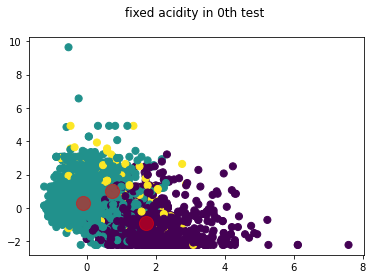

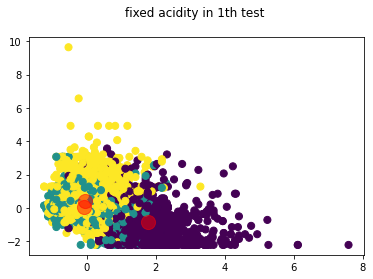

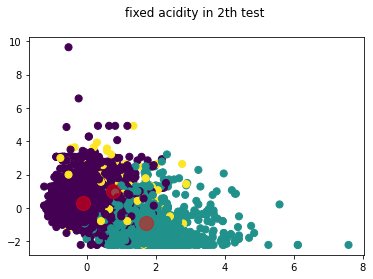

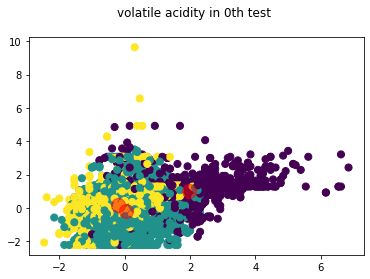

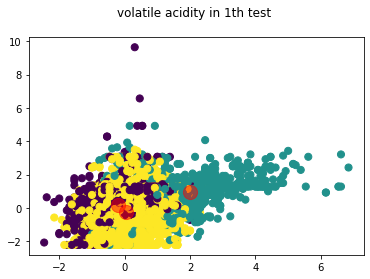

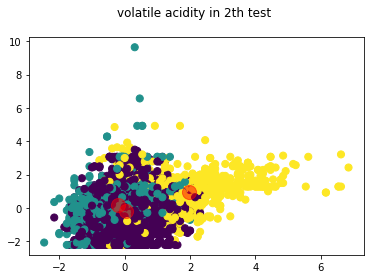

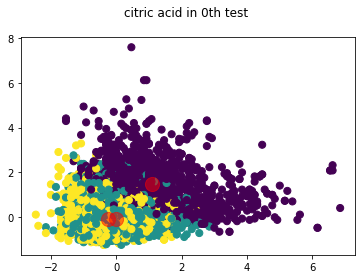

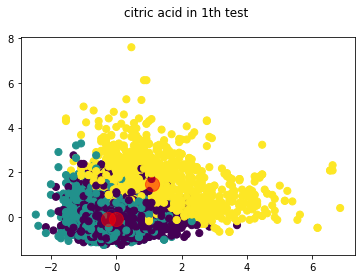

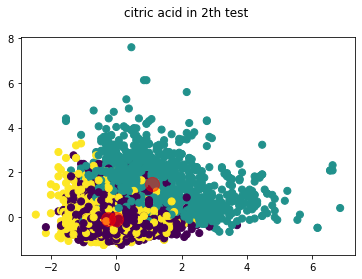

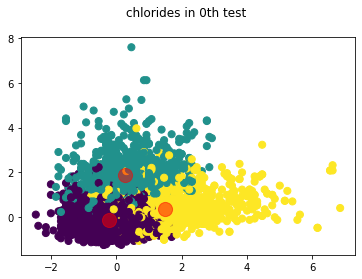

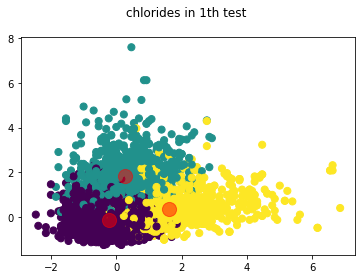

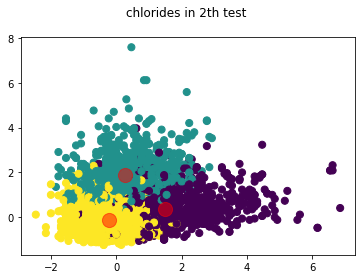

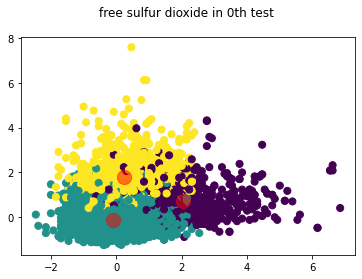

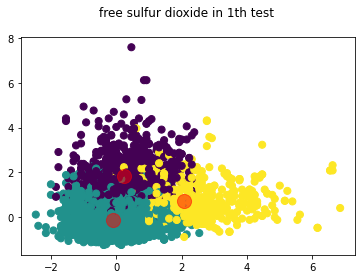

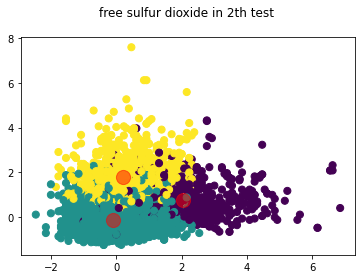

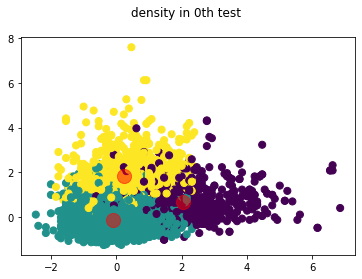

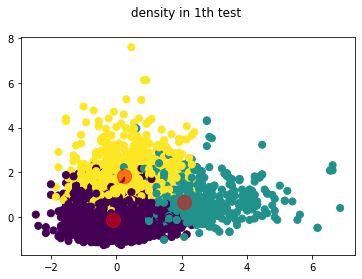

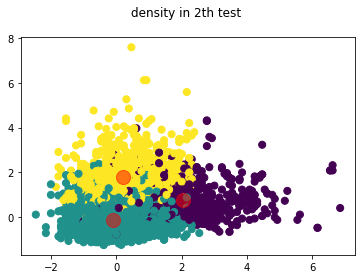

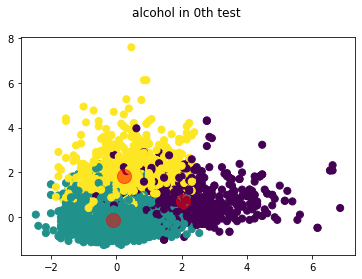

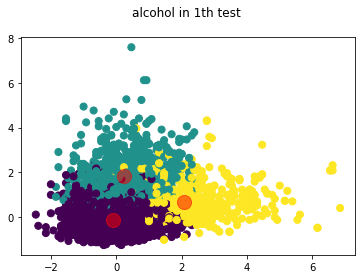

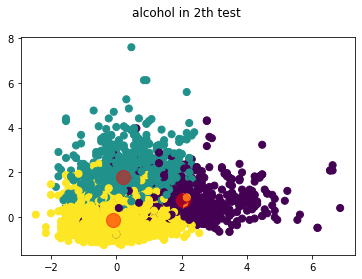

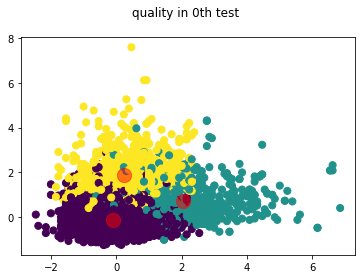

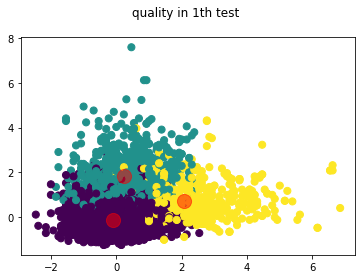

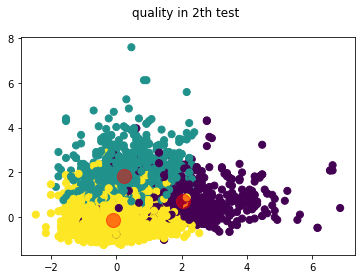

In [57]:
len_target = len(all_label_target)
k = 0
index = 0
lb_3_lst = []
TP_lst_3 = []
FP_lst_3 = []
while index < len_target:
  # Get needed data
  [train, test, y_actual] = needed_data(opt_data, all_label_target[index], index)
  #Train
  pred = []
  centroids = []
  j = 0
  while j < len(train):
    #Train
    model_kmeans = KMeans(n_clusters=3, random_state=0).fit(train[j])
    centroids.append(model_kmeans.cluster_centers_)
    #Test
    pred.append(model_kmeans.predict(test[j]))
    #Confusion Matrix
    dis = np.amax(y_actual[j]) - np.amin(y_actual[j])
    y_actual[j][y_actual[j] < (dis/3)] = 0
    y_actual[j][(y_actual[j] >= (dis/3)) & (y_actual[j] < (dis/3)*2)] = 1
    y_actual[j][y_actual[j] >= (dis/3)*2] = 2
    cmatrix = confusion_matrix(y_actual[j].astype(np.int16), pred[j])
    cm_table = pd.DataFrame(cmatrix)
    cal = re_cm(cmatrix)
    print("THE CONFUSION MATRIX OF {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, cm_table))
    print("The centroids of {0} in {1}th test: \n{2}\n".format(all_label_target[index], j, centroids[j]))
    print("The Accuracy is: {0} \nThe True positive rate is: {1} \nThe False Positive Rate is: {2} \nThe False Negative Rate is:{3} \nThe Precision is {4}\n".format(np.mean(cal[0]), np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])))
    print("The Mean Performance of {0} in {1}th test is: {2}".format(all_label_target[index], j, mean([np.mean(cal[1]), np.mean(cal[2]), np.mean(cal[3]), np.mean(cal[4])])))    
    Khoi_PLOT(train[j], centroids[j], model_kmeans.labels_, k, "{0} in {1}th test \n".format(all_label_target[index], j))
    #Store
    lb_3_lst.append("{0} in {1}th test \n".format(all_label_target[index], j))
    TP_lst_3.append(cal[1])
    FP_lst_3.append(cal[2])
    k += 1
    j += 1
  index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

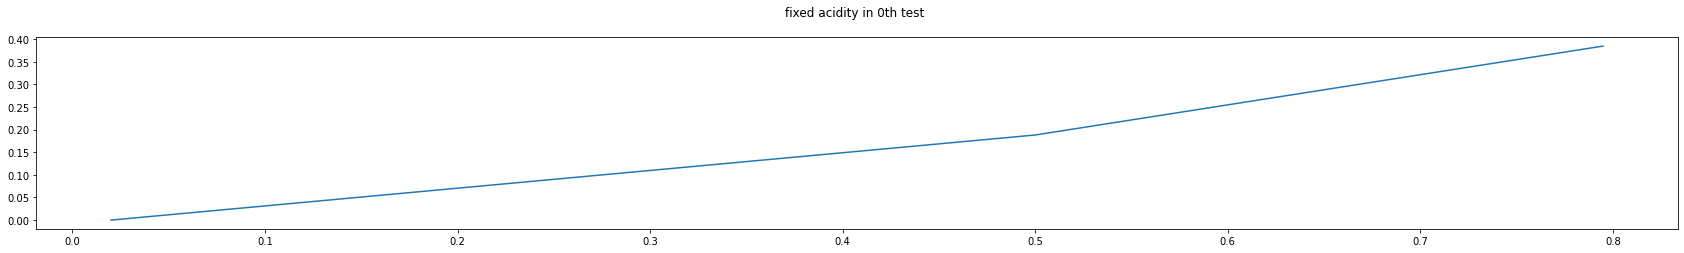

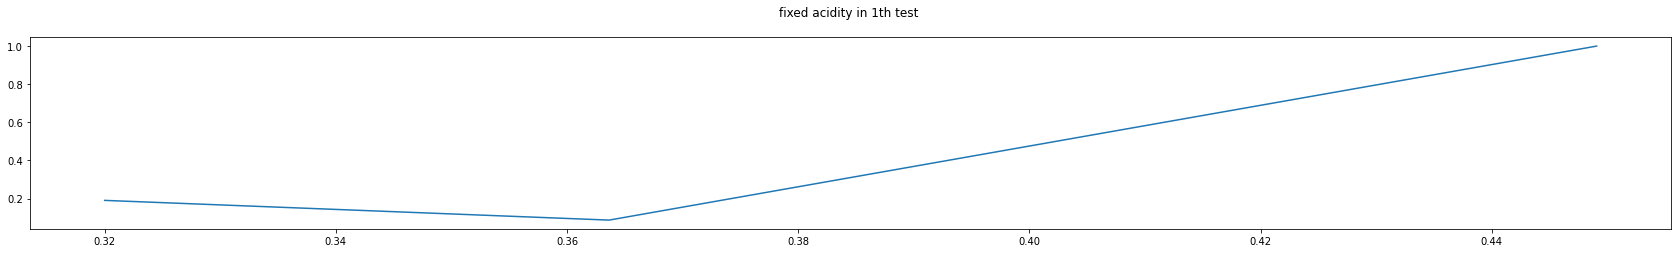

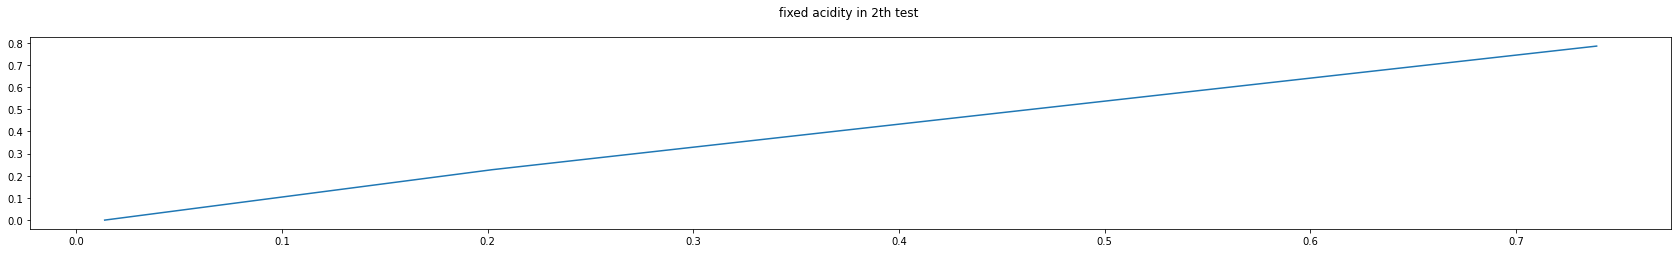

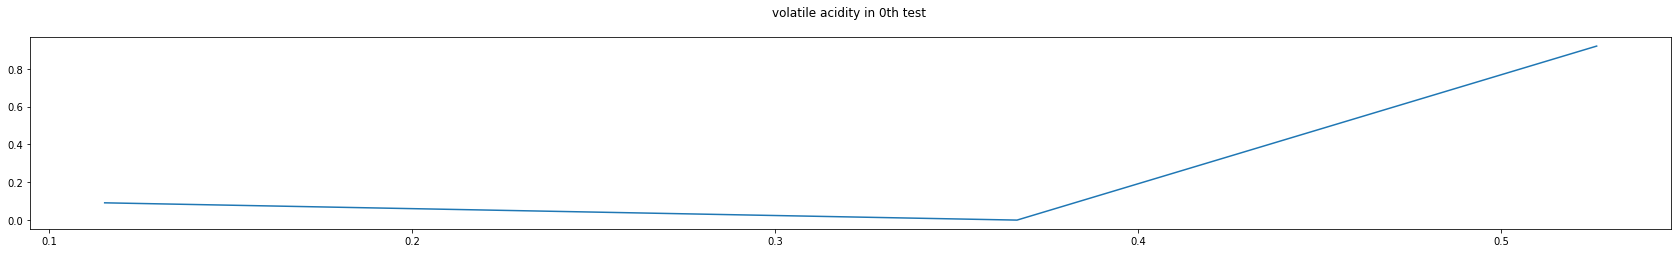

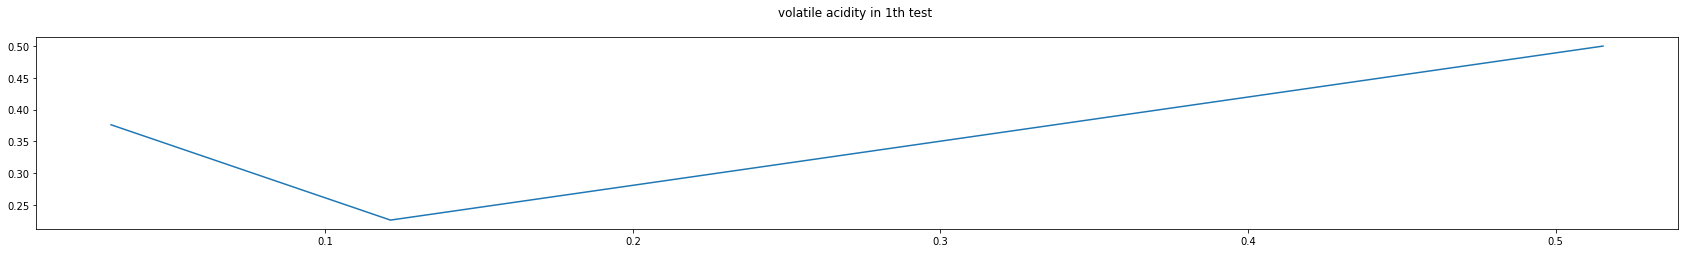

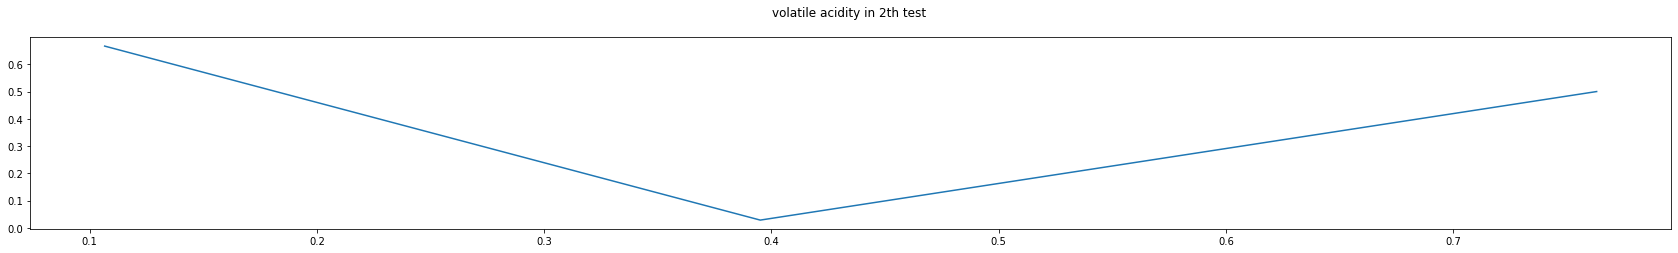

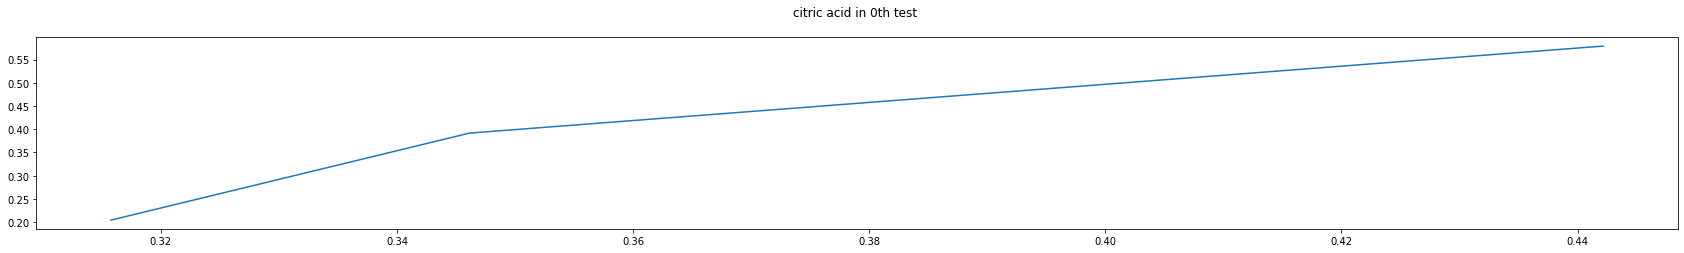

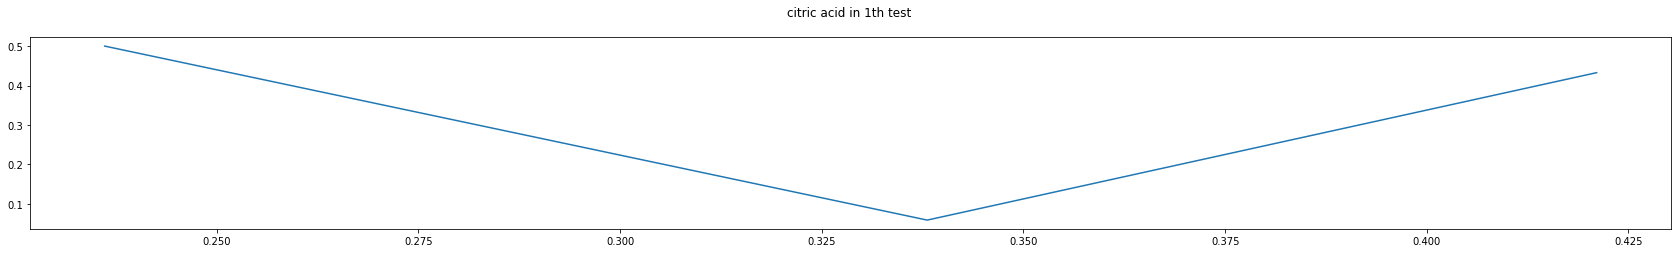

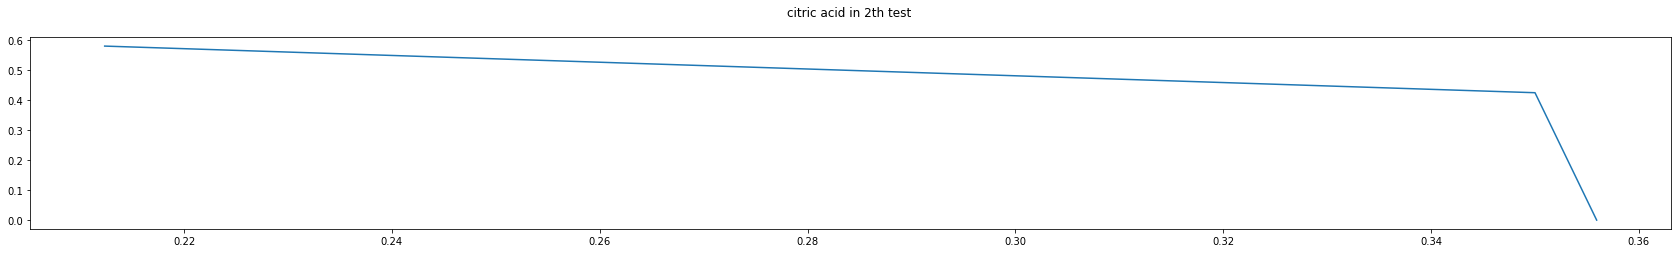

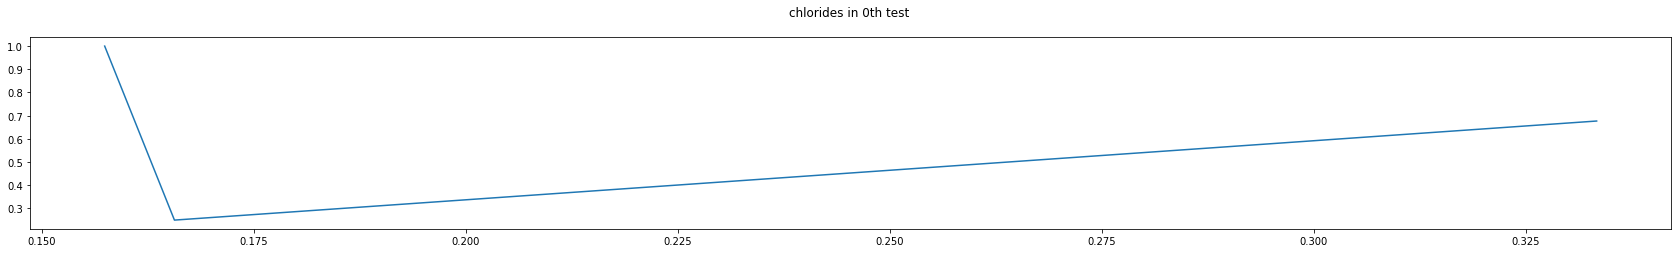

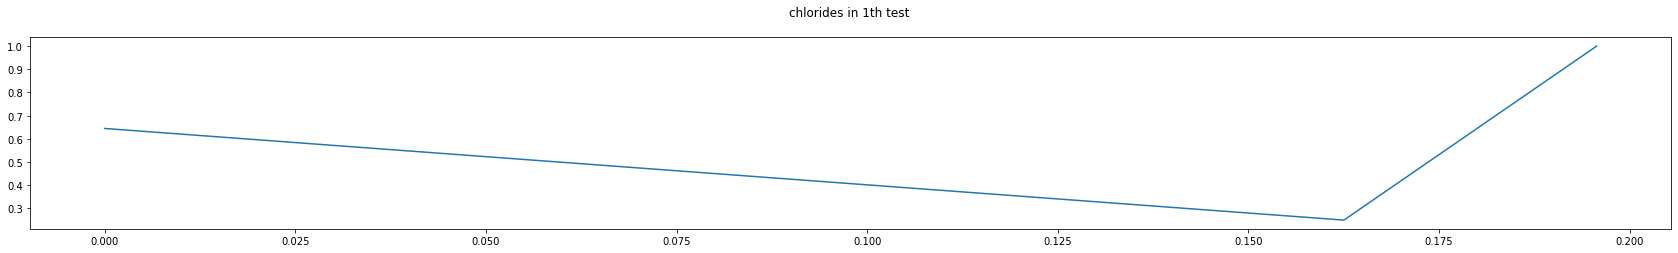

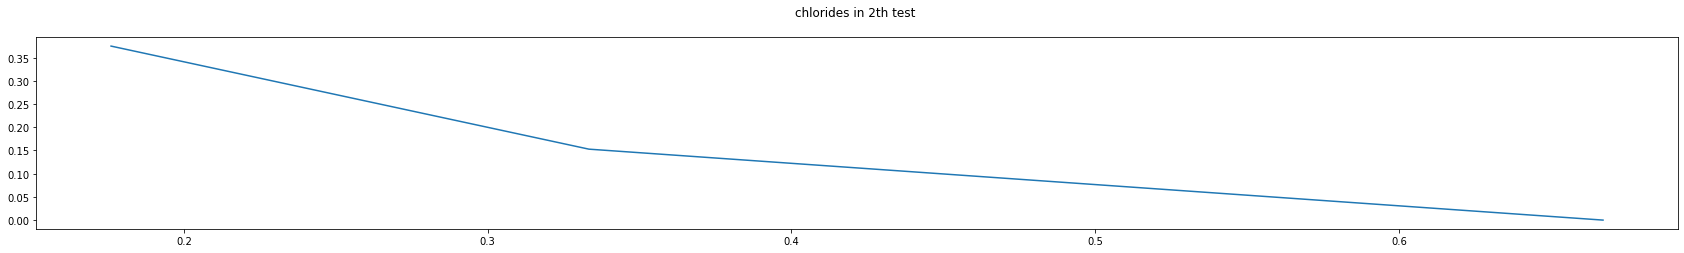

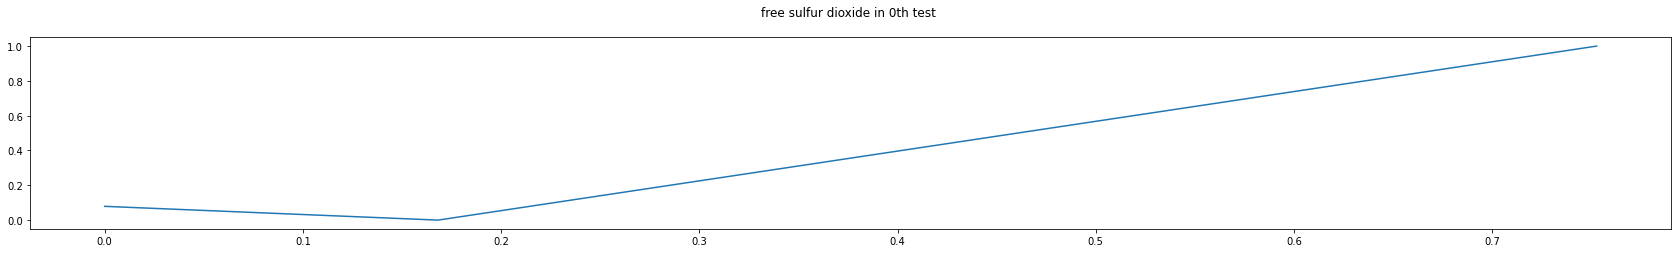

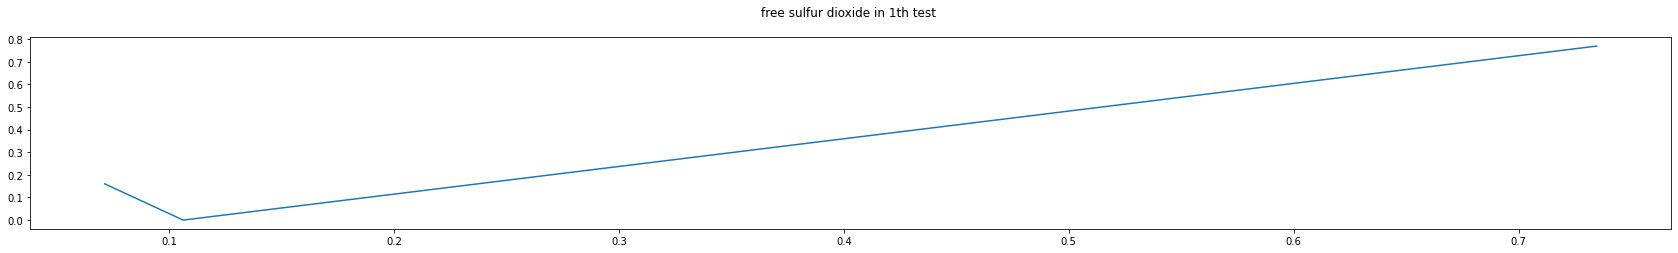

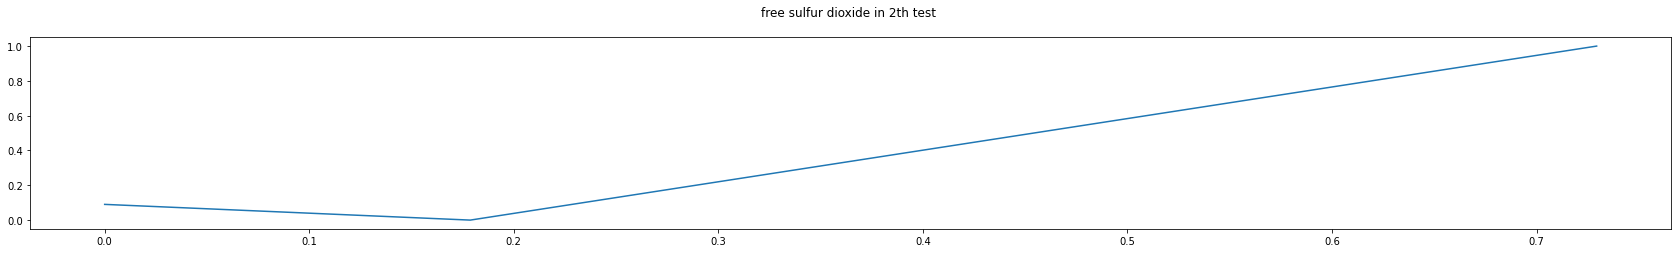

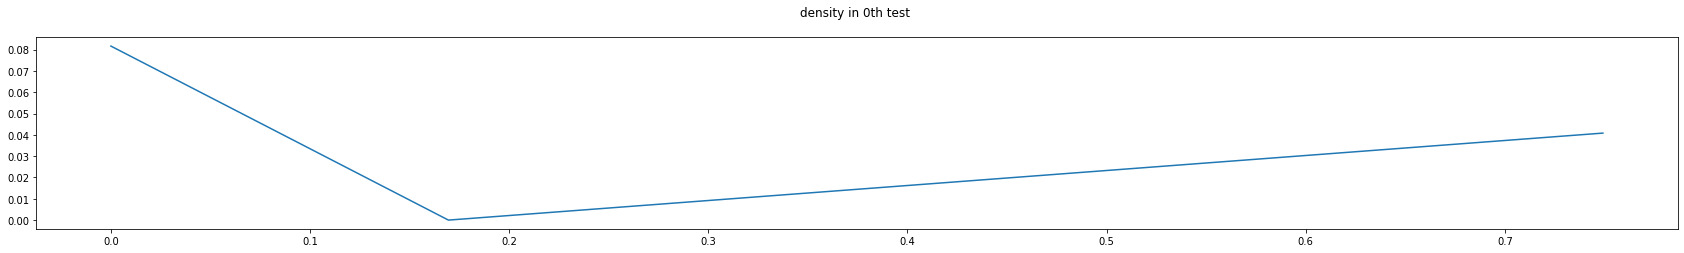

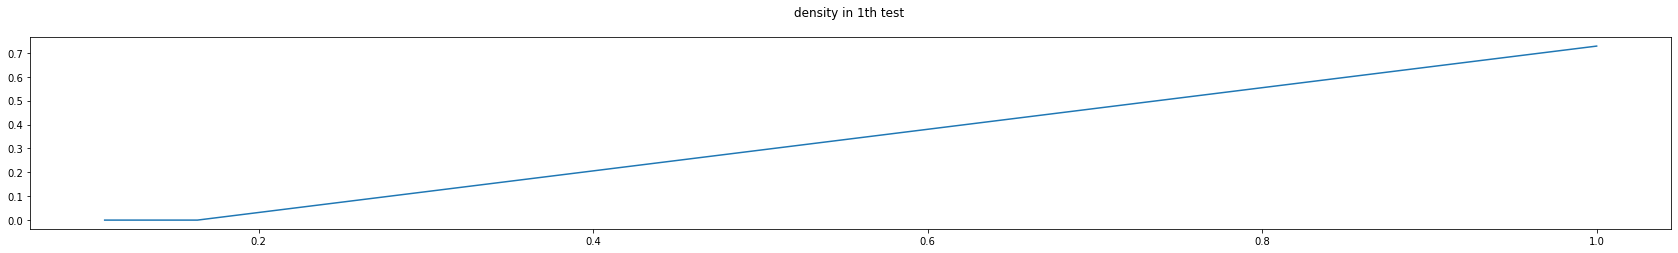

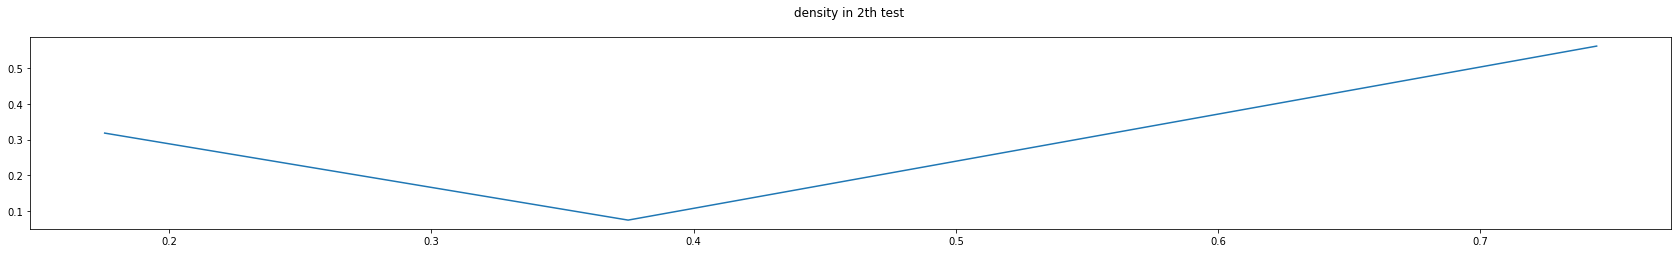

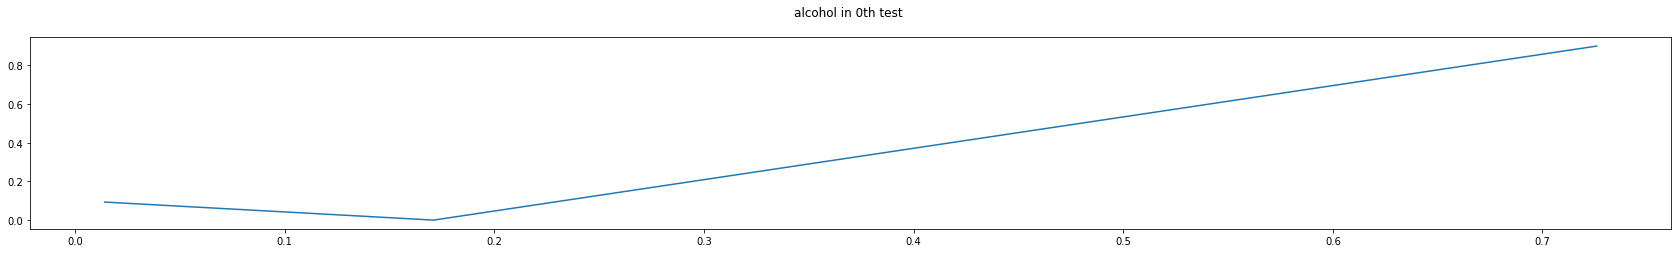

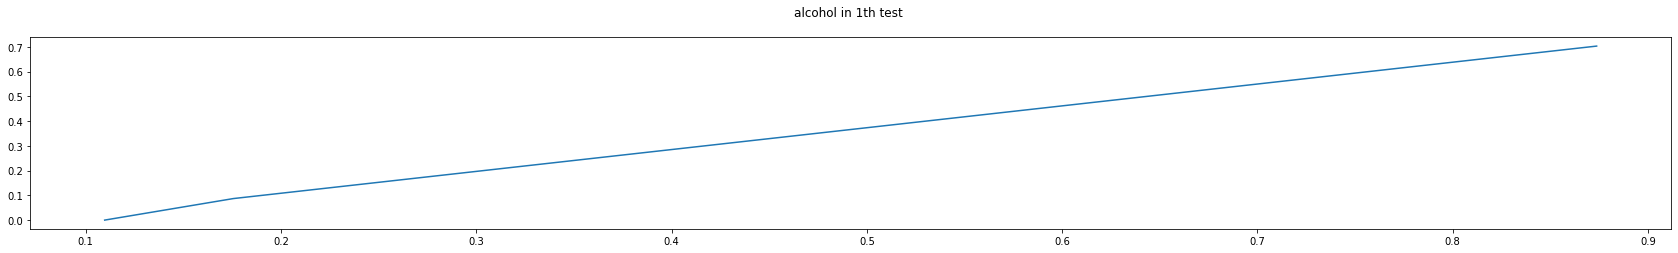

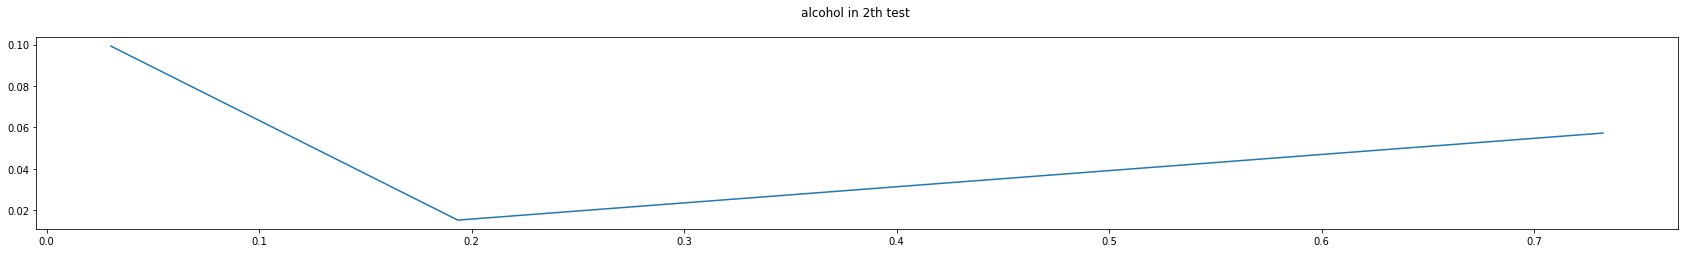

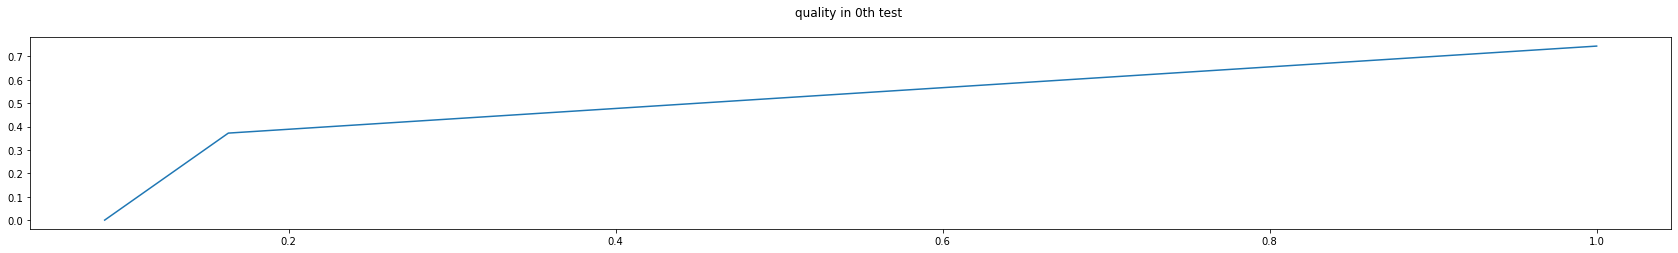

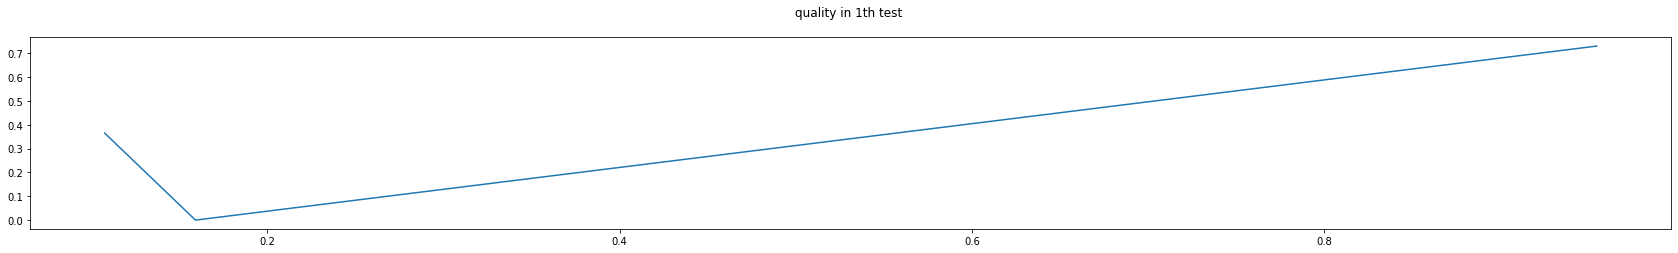

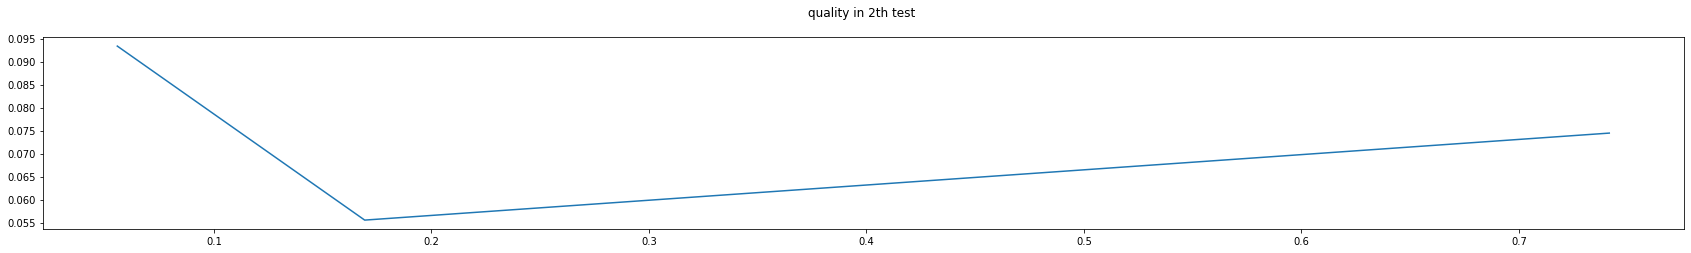

In [58]:
#ROC Curve for 3 cluster
for n in range(len(lb_3_lst)):
  Khoi_ROC(TP_lst_3[n], FP_lst_3[n], n, lb_3_lst[n])